# Low-level image statistics in natural scenes influence perceptual decision-making


In [1]:
"""
Noor Seijdel, 2017
"""
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os.path 
import statsmodels
from statsmodels.stats.anova import AnovaRM
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_ind_from_stats, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
from numpy.random import normal
statsmodels.__version__


'0.8.0.dev0+37f7e05'

## Load data

In [2]:
data = pd.read_csv(u'/media/noor/DataNS/Onderzoek/Projects/Scenestats/SCCE_allparticipants.csv') 
data.head(10)

,Unnamed: 0,Pic,dier,Sc,lmh,SpAc,response,rt,subj_idx,CE,SC,CE_c,SC_c,CE_squared,SC_squared
0,0,120,nD,1,low,Sp,1,0.269,ppn10,0.059630,0.648035,-0.380350,-0.276190,0.144666,0.076281
1,1,152,nD,1,low,Sp,0,0.783,ppn10,0.156877,0.652993,-0.283103,-0.271231,0.080147,0.073566
2,2,23,D,1,low,Sp,1,0.626,ppn10,0.112617,0.632840,-0.327363,-0.291385,0.107167,0.084905
3,3,111,nD,1,low,Sp,1,0.637,ppn10,0.213033,0.725208,-0.226947,-0.199016,0.051505,0.039607
4,4,43,D,1,low,Sp,1,0.366,ppn10,0.267030,0.682406,-0.172950,-0.241819,0.029912,0.058476
5,5,60,D,1,low,Sp,0,0.485,ppn10,0.105226,0.613989,-0.334754,-0.310235,0.112060,0.096246
6,6,54,D,1,low,Sp,1,0.481,ppn10,0.129534,0.706614,-0.310446,-0.217611,0.096377,0.047354
7,7,71,D,1,low,Sp,1,0.480,ppn10,0.138911,0.564420,-0.301069,-0.359804,0.090643,0.129459
8,8,107,nD,1,low,Sp,1,0.439,ppn10,0.128778,0.495516,-0.311202,-0.428708,0.096846,0.183791
9,9,66,D,1,low,Sp,1,0.292,ppn10,0.083869,0.482984,-0.356111,-0.441241,0.126815,0.194693


In [3]:
# preprocessing 
data2use = data[data['rt']>0.1] # remove fast guesses - rt < 100 ms)
data4rt = data2use[data2use['response'] == 1]# remove error trials for RT analysis (correct = 1, error = 0)
data4rt['rt'] = data4rt['rt'].apply(pd.to_numeric)*1000 #RT in ms

In [52]:
#RTs - repeated measures ANOVA with complexity (low, med, high) and instruction (speed, accurate)
means = data4rt.groupby(['subj_idx', 'Sc', 'SpAc'], as_index=False)['rt'].mean()
means['rt'] = means['rt'].round(3) 
df = pd.DataFrame(means)
aovrm = AnovaRM(df, 'rt', 'subj_idx', within=['Sc', 'SpAc'])
fit = aovrm.fit()
print fit

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
Sc      18.7955 2.0000 36.0000 0.0000
SpAc    37.4254 1.0000 18.0000 0.0000
Sc:SpAc  0.2614 2.0000 36.0000 0.7714



In [53]:
#Error rates repeated measures ANOVA with complexity (low, med, high) and instruction (speed, accurate)
totalT = data2use.groupby(['subj_idx', 'Sc', 'SpAc'], as_index=False)['response'].count()
correctT = data2use.groupby(['subj_idx', 'Sc', 'SpAc'], as_index=False)['response'].sum()
totalT['response'] = (1-(correctT['response']/totalT['response'].round(3)))*100

df = pd.DataFrame(totalT)
aovrm = AnovaRM(df, 'response', 'subj_idx', within=['Sc', 'SpAc'])
fit = aovrm.fit()
print fit


                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
Sc      14.3694 2.0000 36.0000 0.0000
SpAc    61.7730 1.0000 18.0000 0.0000
Sc:SpAc  0.1772 2.0000 36.0000 0.8383



### No interaction effects; we collapse over speed and accurate 

              Anova
   F Value Num DF  Den DF Pr > F
--------------------------------
Sc 19.8111 2.0000 36.0000 0.0000

p_eta_s =  [0.52394947382788937]


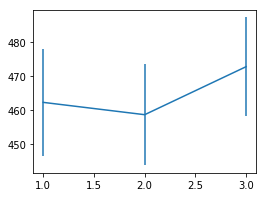

In [50]:
#RTs - collapse over Speed-Accurate (because no interaction effect)
means = data4rt.groupby(['subj_idx', 'Sc'], as_index=False)['rt'].mean()
means['rt'] = means['rt'].round(3)

df = pd.DataFrame(means)
aovrm = AnovaRM(df, 'rt', 'subj_idx', within=['Sc'])
fit = aovrm.fit()
print fit
p_eta_s = [] #compute partial eta squared 
p_eta_s.append((fit.anova_table['F Value'][0]*fit.anova_table['Num DF'][0])/((fit.anova_table['F Value'][0]*fit.anova_table['Num DF'][0])+fit.anova_table['Den DF'][0]))
print 'p_eta_s = ', p_eta_s

fig = plt.figure(figsize =(4,3))
ax = plt.errorbar([1,2,3],means.groupby('Sc')['rt'].mean(), means.groupby('Sc')['rt'].sem())

In [29]:
low_vs_med = ttest_rel(means[means['Sc'] == 1]['rt'], means[means['Sc'] == 2]['rt'])
low_vs_high = ttest_rel(means[means['Sc'] == 1]['rt'], means[means['Sc'] == 3]['rt'])
med_vs_high = ttest_rel(means[means['Sc'] == 2]['rt'], means[means['Sc'] == 3]['rt'])
stats =[low_vs_med[1], low_vs_high[1], med_vs_high[1]]
print "low-med RT - t-stat = %.3f; p-val = %.3f." % low_vs_med
print "low-high RT - t-stat = %.3f; p-val = %.3f." % low_vs_high
print "med-high RT - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high

from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(stats, method='bonferroni')
print p_adjusted

low-med RT - t-stat = 1.567; p-val = 0.135.
low-high RT - t-stat = -3.914; p-val = 0.001.
med-high RT - t-stat = -7.293; p-val = 0.000.

(array([False,  True,  True], dtype=bool), array([  4.03894349e-01,   3.05039684e-03,   2.67580954e-06]), 0.016952427508441503, 0.016666666666666666)


              Anova
   F Value Num DF  Den DF Pr > F
--------------------------------
Sc 14.2626 2.0000 36.0000 0.0000

p_eta_s =  [0.44207798655803782]


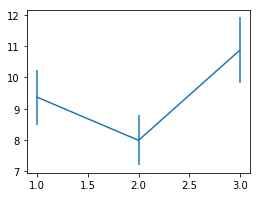

In [51]:
#Error rates collapse over Speed-Accurate (because no interaction effect)
totalT = data2use.groupby(['subj_idx', 'Sc'], as_index=False)['response'].count()
correctT = data2use.groupby(['subj_idx', 'Sc'], as_index=False)['response'].sum()
totalT['response'] = (1-(correctT['response']/totalT['response'].round(3)))*100

df = pd.DataFrame(totalT)
aovrm = AnovaRM(df, 'response', 'subj_idx', within=['Sc'])
fit = aovrm.fit()
print fit
p_eta_s = [] #compute partial eta squared 
p_eta_s.append((fit.anova_table['F Value'][0]*fit.anova_table['Num DF'][0])/((fit.anova_table['F Value'][0]*fit.anova_table['Num DF'][0])+fit.anova_table['Den DF'][0]))
print 'p_eta_s = ', p_eta_s

fig = plt.figure(figsize =(4,3))
ax = plt.errorbar([1,2,3],totalT.groupby('Sc')['response'].mean(), totalT.groupby('Sc')['response'].sem())

In [31]:
low_vs_med = ttest_rel(totalT[totalT['Sc'] == 1]['response'], totalT[totalT['Sc'] == 2]['response'])
low_vs_high = ttest_rel(totalT[totalT['Sc'] == 1]['response'], totalT[totalT['Sc'] == 3]['response'])
med_vs_high = ttest_rel(totalT[totalT['Sc'] == 2]['response'], totalT[totalT['Sc'] == 3]['response'])
stats =[low_vs_med[1], low_vs_high[1], med_vs_high[1]]
print "low-med error - t-stat = %.3f; p-val = %.3f." % low_vs_med
print "low-high error - t-stat = %.3f; p-val = %.3f." % low_vs_high
print "med-high error - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high

from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(stats, method='bonferroni')
print p_adjusted

low-med error - t-stat = 3.405; p-val = 0.003.
low-high error - t-stat = -2.752; p-val = 0.013.
med-high error - t-stat = -4.493; p-val = 0.000.

(array([ True,  True,  True], dtype=bool), array([ 0.00947366,  0.03933254,  0.00084405]), 0.016952427508441503, 0.016666666666666666)
